In [1]:
from edec.afterprocessing import import_labels,load_sql
from edec.preprocessing import compute_cell_dev_array, compute_soc_deviation
import edec.afterprocessing as ap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [121]:
#Annotate db if needed
#ap.annotate_db(sql_db_name="df.db", threshold_soc=9.0, threshold_volt=0.01)

In [2]:
def get_SOC_failed_cells(array):
    """Function what return will which cells is failing"""
    arr = np.array(compute_cell_dev_array(array))
    threshhold = 0.09

    failed_SOC_cells = np.where(arr >0.09)[0]
    return failed_SOC_cells

def get_Volt_failed_cells(array):
    """Function what return will which cells is failing"""
    arr = np.array(compute_cell_dev_array(array))
    threshhold = 0.09

    failed_SOC_cells = np.where(arr >0.09)[0]
    return failed_SOC_cells


def filter_failed_cells(unfiltered_array,failed_cells):
    """Create a filtered list based on failed cells"""
    filtered_array = [unfiltered_array[i] for i in failed_cells]
    return filtered_array

def normalize(x):
    median = np.median(x)
    return (x - median)/median

### Import all tin numbers

In [18]:
df = import_labels(label=1, db="df.db", n_random=10)
# Add column with failed cell
df["Failed cell SOC"] = df["Sorted_SOC"].apply(get_SOC_failed_cells)
df["Failed cell Voltage"] = df["Sorted_Voltage"].apply(get_SOC_failed_cells)
df.head(3)

10 Unique cars with label 1 has been imported with {len(df)} subsamples


,tin_an,timestamp,Sorted_SOC,Sorted_Voltage,Fail,Failed cell SOC,Failed cell Voltage
8,94e1f3623bf8e8e3687c581904e4f9452a5f2cc9d36527...,2020-11-11 13:49:58,"[93.64, 93.7, 93.78, 93.99, 93.81, 93.47, 93.5...","[4.0986, 4.0999, 4.1009, 4.1016, 4.0996, 4.099...",0,[],[]
2046,94e1f3623bf8e8e3687c581904e4f9452a5f2cc9d36527...,2020-11-12 14:14:43,"[82.17, 82.23, 82.33, 82.53, 82.33, 82.04, 82....","[4.0055, 4.0074, 4.0099, 4.0109, 4.0063, 4.006...",0,[],[]
663,b7956f8d0e590d768fde113d72ba654ab2a1261c1b2618...,2020-11-13 06:24:37,"[57.77, 57.75, 57.56, 57.84, 57.74, 57.82, 57....","[3.7717, 3.7716, 3.7696, 3.7725, 3.7714, 3.772...",0,[],[]


### Select individual tin and strip after last fail indication

In [19]:
cars = df["tin_an"].unique()

In [20]:
car = 1
df_tin = df[df["tin_an"] == cars[car]]
df_tin = df_tin.reset_index()

max_index = df_tin[df_tin["Fail"] == 1].index.values
last_idx = max_index[-1]
df_tin = df_tin[:last_idx + 1]

#df_tin = df_tin[df_tin["Fail"] ==1]
#df = df_tin.head(3)

# Apply normalization (deviation)
df_tin["Sorted_SOC_deviation"] = df_tin["Sorted_SOC"].apply(normalize)

df_tin.tail(5)

,index,tin_an,timestamp,Sorted_SOC,Sorted_Voltage,Fail,Failed cell SOC,Failed cell Voltage,Sorted_SOC_deviation
65,1372,b7956f8d0e590d768fde113d72ba654ab2a1261c1b2618...,2021-02-23 14:56:50,"[94.26, 93.73, 93.67, 93.65, 94.35, 93.83, 93....","[4.1442, 4.1392, 4.1385, 4.1382, 4.1447, 4.139...",0,[],[],"[0.0014875375, -0.004143559, -0.004781098, -0...."
66,1355,b7956f8d0e590d768fde113d72ba654ab2a1261c1b2618...,2021-02-24 17:11:30,"[76.71, 76.13, 76.09, 76.11, 76.76, 76.25, 76....","[3.9634, 3.9578, 3.9571, 3.9572, 3.9638, 3.959...",0,[],[],"[0.0026139973, -0.004966735, -0.0054895543, -0..."
67,2010,b7956f8d0e590d768fde113d72ba654ab2a1261c1b2618...,2021-02-25 17:34:47,"[31.93, 31.33, 31.27, 31.24, 32.0, 31.49, 31.3...","[3.5942, 3.5939, 3.5937, 3.5935, 3.5946, 3.594...",0,[],[],"[0.0075733596, -0.01136007, -0.0132533945, -0...."
68,1821,b7956f8d0e590d768fde113d72ba654ab2a1261c1b2618...,2021-02-26 18:05:03,"[51.51, 50.95, 50.89, 50.88, 51.57, 51.13, 51....","[3.7085, 3.7023, 3.7047, 3.7035, 3.7096, 3.704...",0,[],[],"[0.0072350204, -0.0037152646, -0.0048885415, -..."
69,1639,b7956f8d0e590d768fde113d72ba654ab2a1261c1b2618...,2021-02-27 18:23:55,"[46.85, 46.25, 46.21, 46.21, 46.93, 46.41, 46....","[3.5999, 3.6693, 3.6694, 3.586, 3.6002, 3.6713...",1,"[104, 105]",[],"[0.009045836, -0.0038768104, -0.004738342, -0...."


### Sortera ut alla celler som failat

In [21]:
df_failed_cells = df_tin[df_tin["Failed cell SOC"].str.len() != 0]
df_failed_cells.head(5)

,index,tin_an,timestamp,Sorted_SOC,Sorted_Voltage,Fail,Failed cell SOC,Failed cell Voltage,Sorted_SOC_deviation
69,1639,b7956f8d0e590d768fde113d72ba654ab2a1261c1b2618...,2021-02-27 18:23:55,"[46.85, 46.25, 46.21, 46.21, 46.93, 46.41, 46....","[3.5999, 3.6693, 3.6694, 3.586, 3.6002, 3.6713...",1,"[104, 105]",[],"[0.009045836, -0.0038768104, -0.004738342, -0...."


In [22]:
Un = np.array(df_failed_cells["Failed cell SOC"]) # Array with all arrays of failed cells (array[array[1,2], array[1,2])
failed_cells = []
for i in Un:
    failed_cells.extend(list(i))
failed_cells = list(set(failed_cells))
failed_cells.sort()
print(failed_cells)

[104, 105]


### Filtrera ut SOC /Volt data på felade celler

In [23]:
cell_fails = df_tin["Sorted_SOC_deviation"].apply(lambda i:filter_failed_cells(i,failed_cells))
#cell_fails

### Create a new dataframe with failed cells as columns

In [24]:
df_failed_cells["timestamp"].iloc[0]

Timestamp('2021-02-27 18:23:55')

In [25]:
df_clean = pd.DataFrame([x for x in cell_fails])
df_clean.columns = ['Fail_cell_{}'.format(x) for x in failed_cells]
df_clean.insert(0, "timestamp",df_tin["timestamp"])

#df_clean.insert(0, "tin_an",df_tin["tin_an"])
df_clean.set_index('timestamp',inplace=True)
df_clean.head()

,Fail_cell_104,Fail_cell_105
timestamp,,
2020-11-13 06:24:37,0.003708,0.003880
2020-11-14 10:41:42,0.001238,0.000825
2020-11-15 11:32:15,0.002549,0.003668
2020-11-16 11:49:32,0.002541,0.002541
2020-11-17 13:19:00,0.001653,0.002933


'b7956f8d0e590d768fde113d72ba654ab2a1261c1b26182dd2b72136ab5b783b'

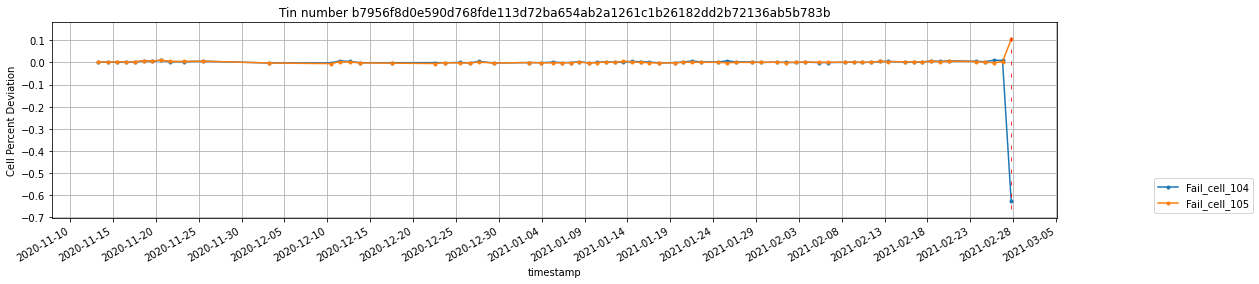

In [43]:
import seaborn as sns
import matplotlib.dates as mdates
dates = df_failed_cells["timestamp"].to_list()
ax =df_clean.plot.line(figsize=(18,4),marker='.')
ymin, ymax = ax.get_ylim()
ax.vlines(x=dates, ymin=ymin, ymax=ymax, color='r',linewidth=0.8, linestyle=(0,(5,10))) # https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/linestyles.html
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5)) 
plt.legend(bbox_to_anchor=(1.2, 0.0), loc='lower right')
ax.set_title(f'Tin number {cars[car]}')
ax.set_ylabel("Cell Percent Deviation")

#plt.axvline(pd.datetime(2021, 1, 21))
#plt.axvline(df_failed_cells["timestamp"].to_list())
plt.grid()
plt.show()

#### Intressant fenomen för:
'94e1f3623bf8e8e3687c581904e4f9452a5f2cc9d365272f055492c143ea64af'

## Plot healthy cells

In [12]:
df = import_labels(label=0, db="df.db", n_random=10)
# Add column with failed cell
df["Failed cell SOC"] = df["Sorted_SOC"].apply(get_SOC_failed_cells)
df["Failed cell Voltage"] = df["Sorted_Voltage"].apply(get_SOC_failed_cells)
df.head(3)

10 Unique cars with label 0 has been imported with {len(df)} subsamples


,tin_an,timestamp,Sorted_SOC,Sorted_Voltage,Fail,Failed cell SOC,Failed cell Voltage
1077,e4622f8eef30fd1b5e97fe8468393c113408ae3fdb9782...,2020-11-11 15:58:32,"[81.83, 81.84, 81.87, 81.84, 81.84, 81.91, 81....","[4.0195, 4.0201, 4.0198, 4.0194, 4.0194, 4.020...",0,[],[]
1031,b1859e5ef1774c6f08171f9217c89883ec67fa1b7be414...,2020-11-11 17:36:02,"[82.03, 82.05, 82.09, 82.07, 82.16, 81.97, 81....","[4.0337, 4.0344, 4.0347, 4.0342, 4.0351, 4.033...",0,[],[]
947,e4622f8eef30fd1b5e97fe8468393c113408ae3fdb9782...,2020-11-12 16:10:52,"[48.23, 48.24, 48.2, 48.24, 48.03, 48.21, 48.0...","[3.6517, 3.6524, 3.6512, 3.651, 3.6506, 3.6521...",0,[],[]


In [167]:
cars = df["tin_an"].unique()

In [193]:
df_tin = df[df["tin_an"] == cars[1]]
df_tin = df_tin.reset_index()

#ax_index = df_tin[df_tin["Fail"] == 1].index.values
#last_idx = max_index[-1]
#df_tin = df_tin[:last_idx + 1]

#df_tin = df_tin[df_tin["Fail"] ==1]
#df = df_tin.head(3)

# Apply normalization (deviation)
df_tin["Sorted_SOC_deviation"] = df_tin["Sorted_SOC"].apply(normalize)

df_tin.tail(5)

,index,tin_an,timestamp,Sorted_SOC,Sorted_Voltage,Fail,Failed cell SOC,Failed cell Voltage,Sorted_SOC_deviation
249,18,62a2889b8aed297d76d55deb8aacf2bb5b7285cb740e4f...,2022-01-27 09:41:31.750,"[84.37, 84.3, 84.37, 83.71, 83.78, 84.27, 83.4...","[4.0522, 4.0514, 4.0489, 4.0408, 4.0459, 4.051...",0,[],[],"[0.0063216416, 0.0054867216, 0.0063216416, -0...."
250,1221,62a2889b8aed297d76d55deb8aacf2bb5b7285cb740e4f...,2022-01-29 11:13:59.668,"[81.93, 81.87, 81.93, 81.26, 81.33, 81.84, 81....","[3.9785, 3.9784, 3.9791, 3.9718, 3.9723, 3.977...",0,[],[],"[0.006634733, 0.005897572, 0.006634733, -0.001..."
251,302,62a2889b8aed297d76d55deb8aacf2bb5b7285cb740e4f...,2022-01-30 10:00:42.133,"[80.21, 80.14, 80.21, 79.56, 79.63, 80.11, 79....","[4.0012, 4.001, 4.0019, 3.9952, 3.9952, 4.0007...",0,[],[],"[0.006651591, 0.005773081, 0.006651591, -0.001..."
252,595,62a2889b8aed297d76d55deb8aacf2bb5b7285cb740e4f...,2022-01-31 10:43:14.006,"[85.83, 85.76, 85.83, 85.18, 85.25, 85.73, 84....","[4.0709, 4.0701, 4.071, 4.064, 4.0646, 4.0697,...",0,[],[],"[0.006272392, 0.005451714, 0.006272392, -0.001..."
253,529,62a2889b8aed297d76d55deb8aacf2bb5b7285cb740e4f...,2022-02-02 14:40:40.794,"[81.57, 81.5, 81.57, 80.91, 80.99, 81.47, 80.7...","[4.0123, 4.0118, 4.0126, 4.0056, 4.0062, 4.011...",0,[],[],"[0.0069748135, 0.0061106733, 0.0069748135, -0...."


In [194]:
df_clean = pd.DataFrame([x for x in df_tin["Sorted_SOC_deviation"]])
df_clean.columns = ['Healthy_cell_{}'.format(x) for x in range(108)]
df_clean.insert(0, "timestamp",df_tin["timestamp"])

#df_clean.insert(0, "tin_an",df_tin["tin_an"])
df_clean.set_index('timestamp',inplace=True)
df_clean.head()

,Healthy_cell_0,Healthy_cell_1,Healthy_cell_2,Healthy_cell_3,Healthy_cell_4,Healthy_cell_5,Healthy_cell_6,Healthy_cell_7,Healthy_cell_8,Healthy_cell_9,...,Healthy_cell_98,Healthy_cell_99,Healthy_cell_100,Healthy_cell_101,Healthy_cell_102,Healthy_cell_103,Healthy_cell_104,Healthy_cell_105,Healthy_cell_106,Healthy_cell_107
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-11-27 17:41:07,-0.003093,-0.002062,-0.001031,-0.001890,0.000000,-0.001890,-0.002578,-0.002750,-0.003437,0.000516,...,-0.002062,-0.002750,-0.001718,-0.001890,-0.002234,0.000516,-0.001890,-0.002062,-0.001547,-0.001718
2020-12-02 13:59:04,-0.001714,-0.001241,-0.000059,-0.000532,0.000295,-0.001241,-0.001359,-0.001832,-0.002305,0.000414,...,-0.001005,-0.000768,-0.000532,-0.000650,-0.001005,0.001004,-0.000886,-0.000886,-0.000532,-0.000768
2020-12-03 15:16:20,-0.005226,-0.004562,-0.003733,-0.005060,-0.003069,-0.004894,-0.005392,-0.005392,-0.005724,-0.003235,...,-0.004728,-0.005558,-0.004065,-0.004562,-0.004728,-0.002737,-0.004397,-0.005060,-0.004562,-0.004728
2020-12-04 15:25:53,0.003203,0.004627,0.006051,0.004864,0.007474,0.005339,0.004864,0.004152,0.003678,0.008661,...,0.007474,0.006288,0.007711,0.007237,0.006525,0.010084,0.006051,0.006051,0.007000,0.006288
2020-12-07 12:41:30,-0.001908,-0.001431,-0.000358,-0.000835,0.000119,-0.001550,-0.001908,-0.002027,-0.002862,0.000238,...,-0.000954,-0.001073,-0.000715,-0.000954,-0.001192,0.000596,-0.001073,-0.001192,-0.000715,-0.000835


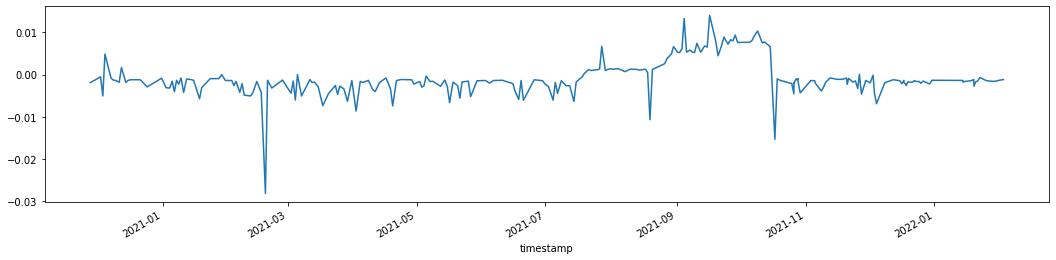

In [206]:
dates = df_tin["timestamp"].to_list()
ax =df_clean.plot.line(y="Healthy_cell_3",figsize=(18,4))
ax.legend_ = None